In [158]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [159]:
consDF = pd.read_parquet("/uss/hdsi-prismdata/q2-ucsd-consDF.pqt")
consDF = consDF.drop(columns = ["credit_score"])
consDF = consDF.dropna()
acctDF = pd.read_parquet("/uss/hdsi-prismdata/q2-ucsd-acctDF.pqt")
trxnDF = pd.read_parquet("/uss/hdsi-prismdata/q2-ucsd-trxnDF.pqt")
catmap = pd.read_csv("/uss/hdsi-prismdata/q2-ucsd-cat-map.csv")

In [3]:
trxnDF.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16


In [4]:
acctDF.head()

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90


In [5]:
trxnDF["signed_amount"] = np.where(
    trxnDF["credit_or_debit"] == "CREDIT",
    trxnDF["amount"],
    -trxnDF["amount"]
)

In [6]:
# net transactions per consumer
txn_sum = (
    trxnDF
    .groupby("prism_consumer_id", as_index=False)["signed_amount"]
    .sum()
    .rename(columns={"signed_amount": "total_transactions"})
)

In [7]:
# initial balance for each consumer
initial_balance = (
    acctDF
    .groupby("prism_consumer_id", as_index=False)["balance"]
    .sum()
    .rename(columns={"balance": "initial_balance"})
)

In [8]:
# final balance for each consumer
final_balance = (
    initial_balance
    .merge(txn_sum, on="prism_consumer_id", how="left")
    .fillna({"total_transactions": 0})
)

final_balance["final_balance"] = (
    final_balance["initial_balance"] +
    final_balance["total_transactions"]
)

final_balance

,prism_consumer_id,initial_balance,total_transactions,final_balance
0,0,320.37,-521.59,-201.22
1,1,3302.42,1805.43,5107.85
2,10,824.24,-1190.04,-365.80
3,100,2655.47,-4505.77,-1850.30
4,1000,95.25,438.08,533.33
...,...,...,...,...
13004,9995,0.00,-121.55,-121.55
13005,9996,252.67,9.14,261.81
13006,9997,611.28,503.19,1114.47
13007,9998,-862.99,-833.10,-1696.09


In [9]:
final_balance[["initial_balance", "final_balance"]].describe()

,initial_balance,final_balance
count,1.300900e+04,1.300900e+04
mean,8.079853e+03,1.003303e+04
std,5.306647e+04,7.794515e+04
min,-9.261490e+03,-4.203443e+05
25%,3.251800e+02,3.805000e+01
50%,1.355610e+03,1.445600e+03
75%,4.953660e+03,6.289820e+03
max,3.598370e+06,5.952758e+06


In [10]:
# number of consumers with <0 initial balance 
(final_balance["initial_balance"] < 0).sum()

369

In [11]:
# number of conumers with <0 final balance
(final_balance["final_balance"] < 0).sum()

2921

In [12]:
# consumers that went from positive to negative balance
(
    (final_balance["initial_balance"] >= 0) &
    (final_balance["final_balance"] < 0)
).sum()

2613

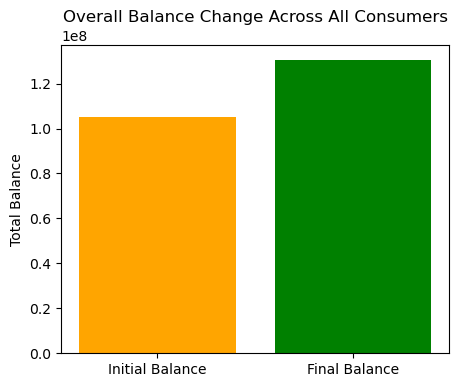

In [13]:
total_initial = final_balance["initial_balance"].sum()
total_final = final_balance["final_balance"].sum()

# Create a simple plot
plt.figure(figsize=(5,4))
plt.bar(["Initial Balance", "Final Balance"], [total_initial, total_final], color=["orange", "green"])
plt.ylabel("Total Balance")
plt.title("Overall Balance Change Across All Consumers")
plt.show()

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


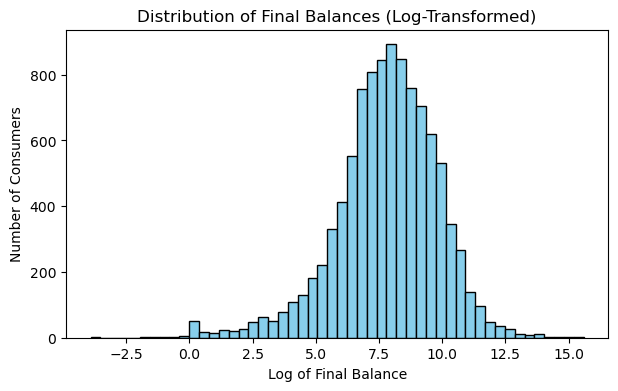

In [14]:
final_balance["final_balance_log"] = np.log1p(final_balance["final_balance"])

plt.figure(figsize=(7,4))
plt.hist(final_balance["final_balance_log"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Log of Final Balance")
plt.ylabel("Number of Consumers")
plt.title("Distribution of Final Balances (Log-Transformed)")
plt.show()

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


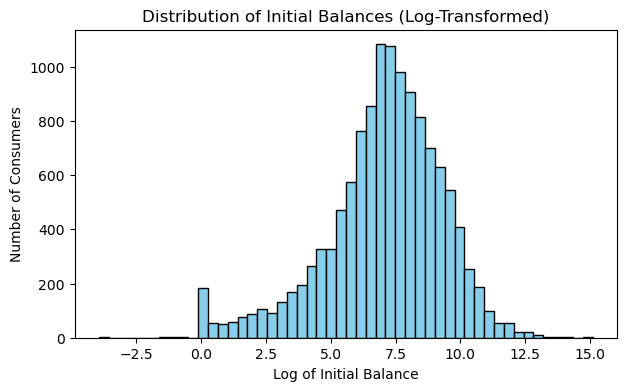

In [15]:
final_balance["initial_balance_log"] = np.log1p(final_balance["initial_balance"])

plt.figure(figsize=(7,4))
plt.hist(final_balance["initial_balance_log"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Log of Initial Balance")
plt.ylabel("Number of Consumers")
plt.title("Distribution of Initial Balances (Log-Transformed)")
plt.show()

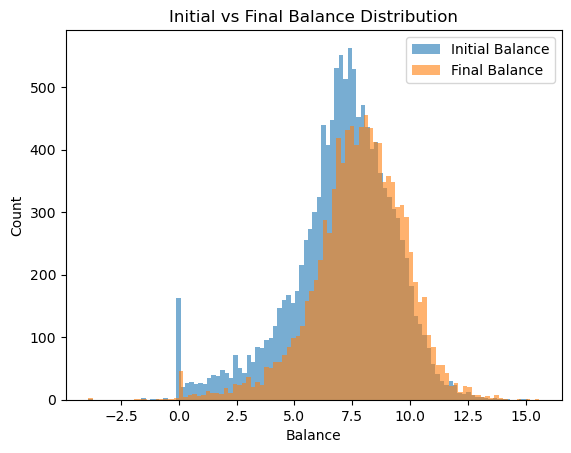

In [16]:
plt.figure()
plt.hist(
    final_balance["initial_balance_log"],
    bins=100,
    alpha=0.6,
    label="Initial Balance"
)
plt.hist(
    final_balance["final_balance_log"],
    bins=100,
    alpha=0.6,
    label="Final Balance"
)
plt.xlabel("Balance")
plt.ylabel("Count")
plt.title("Initial vs Final Balance Distribution")
plt.legend()
plt.show()

In [17]:
sampled = (
    consDF
    .groupby("DQ_TARGET", group_keys=False)
    .apply(lambda x: x.sample(n=5, random_state=40))
)

sampled

/tmp/ipykernel_414/2876161650.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=5, random_state=40))


,prism_consumer_id,evaluation_date,DQ_TARGET
7085,7085,2023-01-18,0.0
5754,5754,2023-04-20,0.0
2894,2894,2022-01-01,0.0
562,562,2022-02-01,0.0
8707,8707,2023-08-26,0.0
8843,8843,2023-08-29,1.0
12221,12221,2022-08-04,1.0
13073,13073,2021-12-23,1.0
7990,7990,2023-11-21,1.0
3099,3099,2021-03-01,1.0


In [18]:
balance_merged = sampled.merge(
    final_balance,
    on="prism_consumer_id",
    how="left"
)

balance_merged

,prism_consumer_id,evaluation_date,DQ_TARGET,initial_balance,total_transactions,final_balance,final_balance_log,initial_balance_log
0,7085,2023-01-18,0.0,1061.38,-15367.86,-14306.48,NaN,6.968267
1,5754,2023-04-20,0.0,5731.78,-1201.05,4530.73,8.418859,8.653956
2,2894,2022-01-01,0.0,9422.39,-10.41,9411.98,9.149845,9.150950
3,562,2022-02-01,0.0,4428.22,1444.86,5873.08,8.678305,8.395979
4,8707,2023-08-26,0.0,952.49,-750.51,201.98,5.313107,6.860129
5,8843,2023-08-29,1.0,2112.46,2115.87,4228.33,8.349799,7.656082
6,12221,2022-08-04,1.0,1141.35,-2753.10,-1611.75,NaN,7.040843
7,13073,2021-12-23,1.0,4169.25,779.31,4948.56,8.507054,8.335731
8,7990,2023-11-21,1.0,588.25,560.42,1148.67,7.047230,6.378851
9,3099,2021-03-01,1.0,27.71,542.96,570.67,6.348562,3.357245


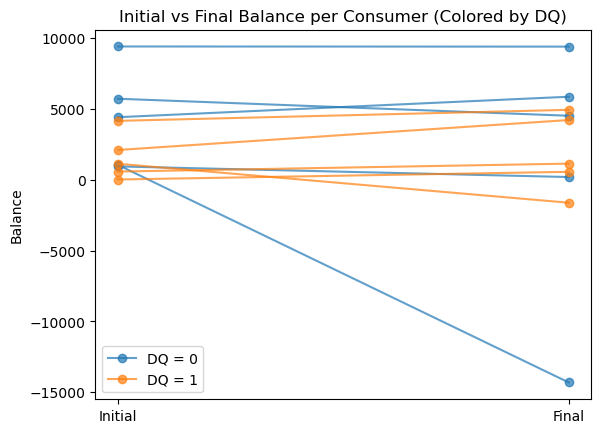

In [19]:
plt.figure()

plotted = set()

for _, row in balance_merged.iterrows():
    if row["DQ_TARGET"] == 0:
        label = "DQ = 0" if "DQ = 0" not in plotted else None
        plt.plot(
            ["Initial", "Final"],
            [row["initial_balance"], row["final_balance"]],
            marker="o",
            color="tab:blue",
            alpha=0.7,
            label=label
        )
        plotted.add("DQ = 0")
    else:
        label = "DQ = 1" if "DQ = 1" not in plotted else None
        plt.plot(
            ["Initial", "Final"],
            [row["initial_balance"], row["final_balance"]],
            marker="o",
            color="tab:orange",
            alpha=0.7,
            label=label
        )
        plotted.add("DQ = 1")

plt.ylabel("Balance")
plt.title("Initial vs Final Balance per Consumer (Colored by DQ)")
plt.legend()
plt.show()

In [45]:
acctDF

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75
24462,11615,24462,SAVINGS,2022-03-30,5.00
24463,11615,24463,CHECKING,2022-03-30,1956.46
24464,12210,24464,CHECKING,2022-03-28,2701.51


In [21]:
acctDF["balance_date"] = pd.to_datetime(acctDF["balance_date"])
dq_check = (
    acctDF
    .groupby(["prism_consumer_id", "account_type"])["balance_date"]
    .nunique()
    .reset_index()
)

In [22]:
# 66 consumers with different balance dates
dq_check[dq_check["balance_date"] != 1]

,prism_consumer_id,account_type,balance_date
827,1056,CHECKING,2
1110,1077,CHECKING,2
1132,1079,CHECKING,2
2031,1147,CHECKING,2
2084,1151,CHECKING,2
...,...,...,...
17093,74,CHECKING,2
19340,896,CHECKING,2
20157,952,CHECKING,2
20172,953,CHECKING,2


In [160]:
acctDF["balance_date"] = pd.to_datetime(acctDF["balance_date"])

acct_consumer = (
    acctDF
    .groupby(["prism_consumer_id", "balance_date"], as_index=False)["balance"]
    .sum()
)

first_snapshot = (
    acct_consumer
    .sort_values("balance_date")
    .groupby("prism_consumer_id", as_index=False)
    .first()
    .rename(columns={
        "balance_date": "start_date",
        "balance": "start_balance"
    })
)

In [161]:
trxnDF["posted_date"] = pd.to_datetime(trxnDF["posted_date"])
trxnDF["signed_amount"] = trxnDF["amount"].where(
    trxnDF["credit_or_debit"] == "CREDIT",
    -trxnDF["amount"]
)

trxn_with_start = trxnDF.merge(
    first_snapshot,
    on="prism_consumer_id",
    how="inner"
)

trxn_with_start = trxn_with_start[
    trxn_with_start["posted_date"] >= trxn_with_start["start_date"]
]

In [162]:
trxn_with_start = trxn_with_start.sort_values(
    ["prism_consumer_id", "posted_date"]
)

trxn_with_start["cum_trxn"] = (
    trxn_with_start
    .groupby("prism_consumer_id")["signed_amount"]
    .cumsum()
)

trxn_with_start["running_balance"] = (
    trxn_with_start["start_balance"] + trxn_with_start["cum_trxn"]
)

In [163]:
start_rows = first_snapshot.rename(columns={
    "start_date": "posted_date",
    "start_balance": "running_balance"
})

start_rows["signed_amount"] = 0.0

running_balance_df = pd.concat([
    start_rows[["prism_consumer_id", "posted_date", "signed_amount", "running_balance"]],
    trxn_with_start[["prism_consumer_id", "posted_date", "signed_amount", "running_balance"]]
]).sort_values(["prism_consumer_id", "posted_date"])

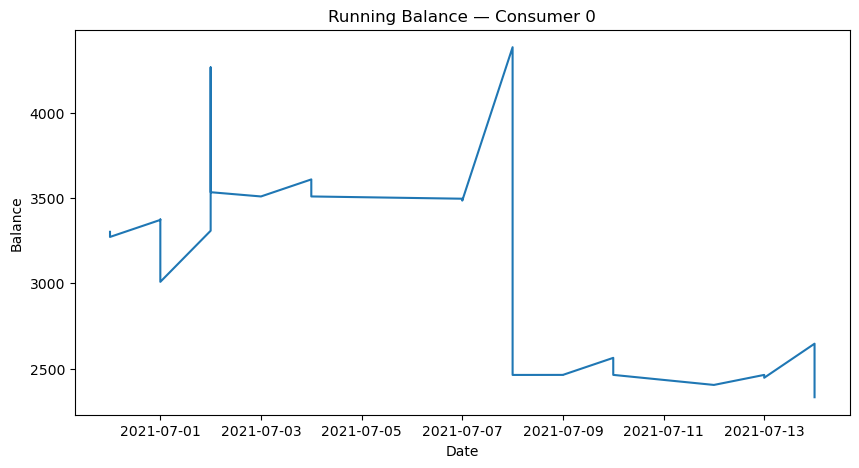

In [164]:
c0 = running_balance_df[
    running_balance_df["prism_consumer_id"] == "1"
]

plt.figure(figsize=(10,5))
plt.plot(c0["posted_date"], c0["running_balance"])
plt.title("Running Balance — Consumer 0")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

In [165]:
consumer_dates = running_balance_df.groupby('prism_consumer_id')['posted_date'].agg(['min', 'max']).reset_index()

# Keep only consumers with at least 1 year (365 days) between first and last transaction
eligible_consumers = consumer_dates[(consumer_dates['max'] - consumer_dates['min']).dt.days >= 365]['prism_consumer_id']

# Filter the original dataframe
filtered_df = running_balance_df[running_balance_df['prism_consumer_id'].isin(eligible_consumers)]
filtered_df

,prism_consumer_id,posted_date,signed_amount,running_balance
3,100,2021-04-30,0.00,802.40
1393298,100,2022-08-01,200.00,1002.40
1393328,100,2022-08-01,-200.00,802.40
1393329,100,2022-08-01,-901.70,-99.30
1393356,100,2022-08-01,-485.72,-585.02
...,...,...,...,...
857374,952,2023-03-13,-37.38,-884.87
857243,952,2023-03-14,50.00,-834.87
857264,952,2023-03-14,-0.00,-834.87
857330,952,2023-03-14,-50.00,-884.87


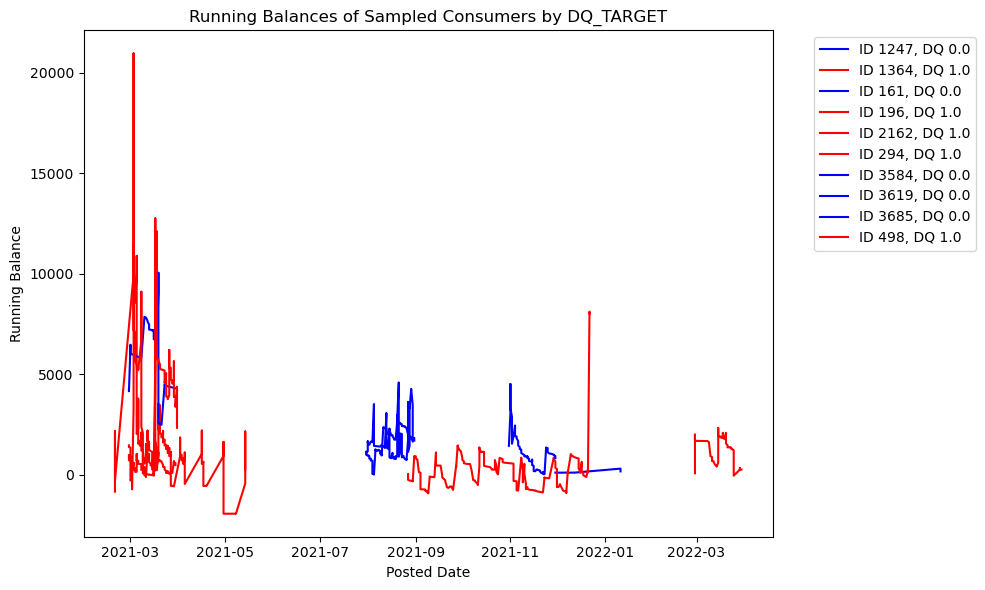

In [166]:
merged_df = running_balance_df.merge(consDF[['prism_consumer_id', 'DQ_TARGET']], on='prism_consumer_id', how='left')

# Filter consumers with at least 1 year between first and last transaction
consumer_dates = merged_df.groupby('prism_consumer_id')['posted_date'].agg(['min','max']).reset_index()
eligible_consumers = consumer_dates[(consumer_dates['max'] - consumer_dates['min']).dt.days >= 30]['prism_consumer_id']

eligible_df = merged_df[merged_df['prism_consumer_id'].isin(eligible_consumers)]

# Sample 5 consumers from each DQ_TARGET
dq0_ids = eligible_df[eligible_df['DQ_TARGET'] == 0]['prism_consumer_id'].drop_duplicates()
dq1_ids = eligible_df[eligible_df['DQ_TARGET'] == 1]['prism_consumer_id'].drop_duplicates()

# Sample if enough exist
dq0_sample = dq0_ids.sample(min(5, len(dq0_ids)), random_state=40)
dq1_sample = dq1_ids.sample(min(5, len(dq1_ids)), random_state=40)

sample_ids = pd.concat([dq0_sample, dq1_sample])

sample_df = eligible_df[eligible_df['prism_consumer_id'].isin(sample_ids)]

# Plot running balances
plt.figure(figsize=(10,6))
colors = {0:'blue', 1:'red'}  # 0 = blue, 1 = red

for cid, group in sample_df.groupby('prism_consumer_id'):
    dq = group['DQ_TARGET'].iloc[0]
    plt.plot(group['posted_date'], group['running_balance'], color=colors[dq], label=f'ID {cid}, DQ {dq}')

plt.xlabel('Posted Date')
plt.ylabel('Running Balance')
plt.title('Running Balances of Sampled Consumers by DQ_TARGET')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()